# The Convolutional Neural Network

### LeCun's LeNet

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

One of the most famous convolutional neural network is [LeNet](https://www.youtube.com/watch?v=FwFduRA_L6Q) and was introduced by [Yann LeCun](http://yann.lecun.com/) in 1989. At the end of the '80s, he worked with some colleagues at [Bell Labs](https://en.wikipedia.org/wiki/Bell_Labs) on the **first convolutional neural network trained with backpropagation**. The goal of this CNN was to recognize handwritten digits (zip codes) from the US post office (LeCun et al, 1989). In 1998 and after some years of research, the [LeNet-5](http://yann.lecun.com/exdb/lenet/) reached test error rates of 0.95% (99.05 of classification accuracy) in the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) (LeCun et al, 1998).

#### The convolution operation

<center>
<img src="https://drive.google.com/uc?export=view&id=1Anvhn8izK2wyn7jWmZXcqUmmcb8b1HIm">
</center>

### CNN Hierarchical Representation

<center>
<img src="https://drive.google.com/uc?export=view&id=1lBzdLimOC9y5rX0neZDuzDi_88GXIH_H">
</center>
<center>Figure: Hierarchical Representation</center>


<center>
<img src="https://drive.google.com/uc?export=view&id=1KyTDluO9hx23T92lSA-LfR9Pqiqi8Ncd">
</center>
<center>Figure: Hierarchical Representation</center>

## Project: Pytorch implementation

### MNIST classification with LeNet-5

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

In [1]:
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scipy-1.9.3-cp39-cp39-win_amd64.whl (40.2 MB)
  Using cached matplotlib-3.6.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached scikit_learn-1.1.3-cp39-cp39-win_amd64.whl (7.6 MB)
  Using cached contourpy-1.0.6-cp39-cp39-win_amd64.whl (161 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached Pillow-9.3.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached numpy-1.23.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Using cached kiwisolver-1.4.4-cp39-cp39-win_amd64.whl (55 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [5]:
import time
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os as os

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

#### General settings

In [26]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10

# Architecture
num_classes = 10

dataset_dir = 'data'

num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 32   # Using minibatches of 128 samples

#### Dataset
In this example, we will use the standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
The MNIST dataset contains of handwritten digits (i.e. 0 to 9) and is used in image classification.


In [18]:
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

#transform pictures from 28x28 -> 32x32
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Load the dataset for the training/validation sets
# Note transforms.ToTensor() scales input images
# to 0-1 range [0,255]=>[0,1]
# You should also investigate how different types of data augmentation operations affect the training results
train_valid_dataset = datasets.MNIST(root=dataset_dir, 
                                     train= True, 
                                     transform = resize_transform, 
                                     download = True)
# 60K images of 28x28 pixels

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [nb_train, nb_valid])

In [19]:
test_dataset = datasets.MNIST(root=dataset_dir, train=False, transform=transforms.ToTensor(), download=True)

##### Loading Dataset
**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads) # initialise train data loader

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads) # initialise validation data loader

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads) # initialise test data loader

In [21]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 1500 batches
The validation set contains 12000 images, in 375 batches
The test set contains 10000 images, in 313 batches


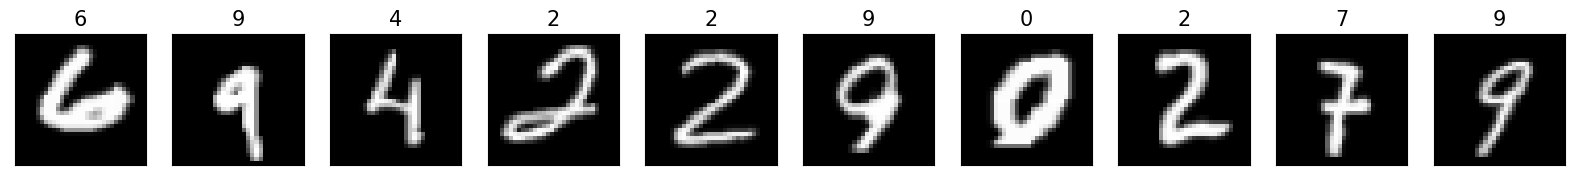

In [22]:
nsamples = 10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(train_loader)) # visualise some training images

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In order to create the LeNet5, we are going to use:
*   the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer 
*   the [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) convolutional operator and 
*   the [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) operator 
of PyTorch.

<center>
<img src="https://drive.google.com/uc?export=view&id=1Anvhn8izK2wyn7jWmZXcqUmmcb8b1HIm">
</center>

In [44]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Tanh

class LeNet5(nn.Module):

    def __init__(self, num_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.num_classes = num_classes
        self.in_channels = in_channels

        self.features = nn.Sequential(
            # Conv2d, kernel_size=5, 6 filters, stride is not needed->stride is how many pixels should be jumped in between
            nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, stride=1, padding='valid'),
            #nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding='valid'),
            # Tanh
            nn.Tanh(),
            # MaxPool2 -> applies over every channel -> amount of channels the same but half the size (28x28->14x14)
            nn.MaxPool2d(kernel_size=2),
            # Conv2d kernel_size=5, 16 filters, 6 in channels means that every kernel/filter has 6 channels, there are 16 kernels on this level
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            # Tanh
            nn.Tanh(),
            # MaxPool2
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            # Linear Layer, in=400, out 120, 400 comes from the 16 channels times 5x5 => 400
            nn.Linear(in_features=400, out_features=120),
            # Tanh
            nn.Tanh(),
            # Linear Layer, in=120, out 84
            nn.Linear(in_features=120, out_features=84),
            # Tanh
            nn.Tanh(),
            # Linear Layer, in=84, out 10
            nn.Linear(in_features=84, out_features=num_classes)
        )


    def forward(self, x): 
        x = self.features(x) # get features
        x = torch.flatten(x, 1) # [32, 32, 32] => [32, 32*32]
        logits = self.classifier(x) # classification ¦ logits is the preactivation function in a neural network
        probas = F.softmax(logits,dim=1) # softmax
        return logits, probas

In [46]:
model = LeNet5(num_classes=num_classes)
print(model)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

61706


##### Loss function
Pytorch provides the 
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

For now, back to our experiment, we just need to instantiate the loss :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
```

Alternatively, you can use the [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#nll-loss) function and pass as parameter the result of having applied the `F.log_softmax( )` to your inputs.

In [ ]:
loss_func = ...

##### Optimizer
In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

In [ ]:
optimizer = ...
#optimizer = ...

##### Train
Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.


- Learning Process:
    1. Put inputs/labels into GPU device.
    2. Do forward propagation => Predictions
    3. Compute Loss function
    4. Do backward propagation => Gradients w.r.t. parameters
    5. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    6. REPEAT learning process

In [ ]:
def compute_accuracy_and_loss(model, data_loader, device):
    
    correct_pred, num_examples = 0, 0
    
    cross_entropy = 0.

    for ii, (features, targets) in enumerate(data_loader):
            
        features = ... # X
        targets = ... # y

        logits, probas = ... # forward propagation z=logits, a=f(z)
        cross_entropy += ...

        _, predicted_labels = ... # y_hat=predicted_labels
        num_examples += ...

        correct_pred += ...

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [ ]:
def train(model, num_epochs, train_loader, valid_loader):
  
  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in ...

      model.train()

      for batch_idx, ...
          
          features = ... # X to device
          targets = ... # Y to device
              
          # forward-propagation
          logits, probas = ...

          # compute cost function
          cost = ...

          # clean gradients
          ...
          
          # compute derivatives (backward propagation)
          ...

          # append minibatch cost
          minibatch_cost...
          
          # update model parameters
          ... # w = w - learning_rate * partial_deriv_error
          
          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost))
              
      with torch.set_grad_enabled(False):
          train_acc, train_loss = ...
          valid_acc, valid_loss = ...

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))
          
          train_acc_lst...
          valid_acc_lst...
          train_loss_lst...
          valid_loss_lst...

          if valid_acc > best_acc:
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')

          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return ..., ..., ..., ..., ...

In [ ]:
..., ..., ..., ..., ... = train(..., ..., ..., ...)

Epoch: 00001/00030 | Batch 00000/01500 | Cost: 0.3074
Epoch: 00001/00030 | Batch 00050/01500 | Cost: 0.4300
Epoch: 00001/00030 | Batch 00100/01500 | Cost: 0.2386
Epoch: 00001/00030 | Batch 00150/01500 | Cost: 0.3940
Epoch: 00001/00030 | Batch 00200/01500 | Cost: 0.3687
Epoch: 00001/00030 | Batch 00250/01500 | Cost: 0.2625
Epoch: 00001/00030 | Batch 00300/01500 | Cost: 0.1522
Epoch: 00001/00030 | Batch 00350/01500 | Cost: 0.3345
Epoch: 00001/00030 | Batch 00400/01500 | Cost: 0.2212
Epoch: 00001/00030 | Batch 00450/01500 | Cost: 0.0272
Epoch: 00001/00030 | Batch 00500/01500 | Cost: 0.0726
Epoch: 00001/00030 | Batch 00550/01500 | Cost: 0.3405
Epoch: 00001/00030 | Batch 00600/01500 | Cost: 0.0842
Epoch: 00001/00030 | Batch 00650/01500 | Cost: 0.2823
Epoch: 00001/00030 | Batch 00700/01500 | Cost: 0.1316
Epoch: 00001/00030 | Batch 00750/01500 | Cost: 0.0236
Epoch: 00001/00030 | Batch 00800/01500 | Cost: 0.0711
Epoch: 00001/00030 | Batch 00850/01500 | Cost: 0.0272
Epoch: 00001/00030 | Batch 0

##### Results

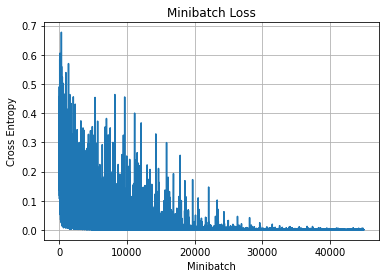

In [ ]:
plt.plot(..., ...)
plt.title('Minibatch Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.grid()
plt.show()

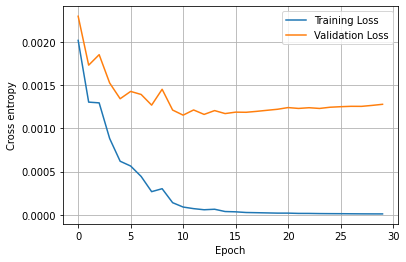

In [ ]:
plt.plot(..., ..., label='Training Loss')
plt.plot(..., ..., label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

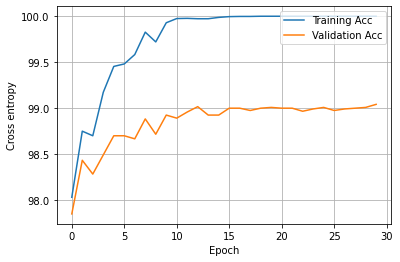

In [ ]:
plt.plot(..., ..., label='Training Acc')
plt.plot(..., ..., label='Validation Acc')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

We compute the accuracy on the test set as follows:

In [ ]:
test_acc, test_loss = ...
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 99.03%


In [ ]:
# obtain one batch of test images
data_iter = iter(test_loader)
images, targets = data_iter.next()

In [ ]:
# get sample outputs
logits, probas = ...

# convert output probabilities to predicted class
_, preds = ...

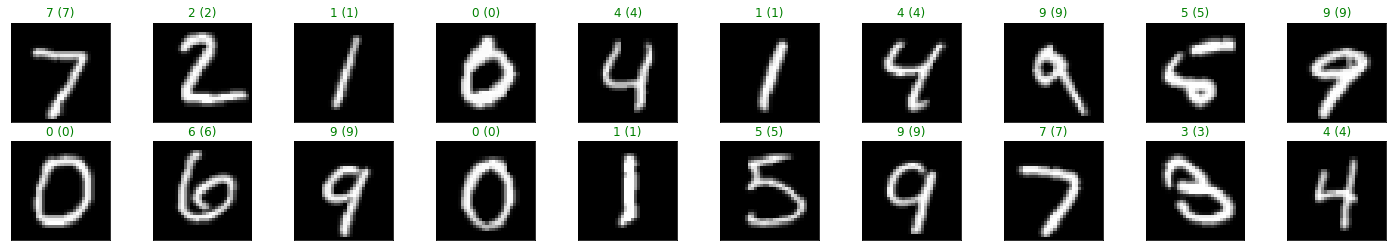

In [ ]:
# plot the images in the batch, along with predicted and true targets
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(targets[idx].item())),
                 color=("green" if preds[idx]==targets[idx] else "red"))

In [ ]:
# calculating the confusion matrix
cm = ...
print(cm)

[[5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 5]]


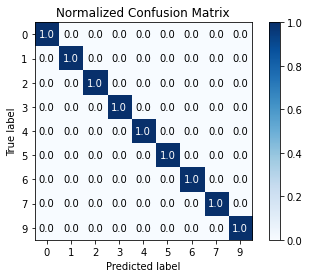

In [ ]:
skplt.metrics.plot_confusion_matrix(targets,preds, normalize=True)